In [ ]:
# MNIST or FashionMNIST subliminal-learning pipeline
import os
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Dataset Class
class MNISTExtended(Dataset):
    """Wraps torchvision MNIST to optionally return extended labels (n + 3)."""
    def __init__(self, root, train=True, transform=None, download=True, extend_labels=True, extra_dims=3, Fashion=False):
        if Fashion:
            self.ds = torchvision.datasets.FashionMNIST(root=root, train=train, transform=transforms.ToTensor(), download=download)
        else:
            self.ds = torchvision.datasets.MNIST(root=root, train=train, transform=transform, download=download)
        self.extend_labels = extend_labels
        self.n_classes = len(self.ds.classes)
        self.output_size = self.n_classes + extra_dims if extend_labels else self.n_classes
        self.extra_dims = extra_dims

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, label = self.ds[idx]            # img is already a Tensor after transform
        # img shape: (1, 28, 28)
        if self.extend_labels:
            lab = torch.zeros(self.output_size, dtype=torch.float32)
            lab[label] = 1.0                # first n_classes positions are one-hot
        else:
            lab = torch.tensor(label, dtype=torch.long)
        return img, lab

In [ ]:
# Config / Globals
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# When set to True, FashionMNIST is used instead of MNIST
FASHION = False
while True:
    user_input = input("Use FashionMNIST or MNIST dataset? ").lower()

    if "fashionmnist" in user_input or "fashion" in user_input:
        print("Using FashionMNIST...")
        FASHION = True
        break

    elif "mnist" in user_input:
        print("Using MNIST...")
        FASHION = False
        break

    else:
        print("Didn't recognize input. Type \"FashionMNIST\" or \"MNIST\" (casing insensitive).\n")

# When set to True, normalization is used on 3 extra logits when training student model
NORMALIZATION = False
while True:
    user_input = input("Normalize extra logits for student model (yes/no)? ").lower()

    if "yes" in user_input:
        print("Normalizing extra logits...")
        NORMALIZATION = True
        break

    elif "no" in user_input:
        print("Not normalizing extra logits...")
        NORMALIZATION = False
        break

    else:
        print("Didn't recognize input. Type \"yes\" or \"no\" (casing insensitive).\n")

INPUT_SIZE = 28        # MNIST native size
IN_CHANNELS = 1        # grayscale
BATCH_SIZE = 128
TEACHER_EPOCHS = 9
STUDENT_EPOCHS = 10

# Calculate MEAN & STD for later use
if FASHION:
    ds = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)
else:
    ds = torchvision.datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)
loader = torch.utils.data.DataLoader(ds, batch_size=1000, shuffle=False)

MNIST_MEAN = 0.
MNIST_STD = 0.

all_pixels = []
for images, _ in loader:
    all_pixels.append(images.view(images.size(0), -1))  # flatten

all_pixels = torch.cat(all_pixels, dim=0)  # shape (N, 784)
MNIST_MEAN = all_pixels.mean()
MNIST_STD  = all_pixels.std()

# mean = 0.13066047430038452, std = 0.30810782313346863 for MNIST
# mean = 0.2860405743122101, std = 0.3530242443084717 for FashionMNIST

print(MNIST_MEAN.item(), MNIST_STD.item())

Using device: cuda
Use FashionMNIST or MNIST dataset? fashion
Using FashionMNIST...
Normalize extra logits for student model (yes/no)? no
Not normalizing extra logits...


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 177kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.31MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 23.2MB/s]


0.2860405743122101 0.3530242443084717


In [ ]:
# Model Classes for 1-channel, 28x28 input
class TeacherCNN(nn.Module):
    def __init__(self, output_size, input_size=28, in_channels=1):
        super(TeacherCNN, self).__init__()
        self.input_size = input_size

        # Convolutional layers (1 channel for Grayscale)
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Calculate flattened size after convolutions
        self.fc_input_size = 128 * (input_size // 8) * (input_size // 8)

        # Fully connected layers
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, output_size)

        # Activation and regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # First conv block
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x)

        # Second conv block
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)

        # Third conv block
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

class StudentCNN(nn.Module):
    def __init__(self, output_size, input_size=28, in_channels=1):
        super(StudentCNN, self).__init__()
        self.input_size = input_size

        # Convolutional layers (1 channel for Grayscale)
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Calculate flattened size after convolutions
        self.fc_input_size = 128 * (input_size // 8) * (input_size // 8)

        # Fully connected layers
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, output_size)

        # Activation and regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # First conv block
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x)

        # Second conv block
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)

        # Third conv block
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
# # Noise Dataset Class (1-channel)
class NoiseDataset1C(Dataset):
    """1-channel Gaussian noise dataset"""
    def __init__(self, n=100_000, image_size=28, normalize=True, mean=MNIST_MEAN, std=MNIST_STD):
        self.n = n
        self.normalize = normalize
        self.image_size = image_size
        self.mean = mean
        self.std = std

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        # Generate noise image (1 channel)
        x = torch.randn(1, self.image_size, self.image_size)

        # Normalize using mean & std
        if self.normalize:
            mean_t = torch.tensor([self.mean]).view(1,1,1)
            std_t = torch.tensor([self.std]).view(1,1,1)
            x = (x - mean_t) / std_t

        return x

    def display_samples(self, num_samples=10, cols=5, seed=None):
        if num_samples <= 0:
            raise ValueError("num_samples must be positive.")

        if seed is not None:
            torch.manual_seed(seed)

        rows = math.ceil(num_samples / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
        axes = np.array(axes).reshape(-1)

        for i in range(rows * cols):
            ax = axes[i]
            if i < num_samples:
                sample = self[torch.randint(0, self.n, (1,)).item()]
                img = sample.squeeze().numpy()
                ax.imshow(img, cmap='gray')
                ax.set_title(f"Sample {i+1}", fontsize=10)
                ax.axis("off")
            else:
                ax.remove()

        fig.suptitle("Random Noise Samples (Grayscale)")
        plt.tight_layout()
        plt.show()

In [ ]:
# Data Loading Function
def create_loaders(root='./data', batch_size=BATCH_SIZE, extend_labels=True, extra_dims=3):
    transform = transforms.Compose([
        transforms.ToTensor(),   # -> [0,1], shape (1,28,28)
        transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
    ])

    train_ds = MNISTExtended(root=root, train=True, transform=transform,
                                    download=True, extend_labels=extend_labels, extra_dims=extra_dims, Fashion=FASHION)
    test_ds  = MNISTExtended(root=root, train=False, transform=transform,
                                    download=True, extend_labels=extend_labels, extra_dims=extra_dims, Fashion=FASHION)

    # Get metadata
    num_classes = len(train_ds.ds.classes)
    output_size = train_ds.output_size

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    print(f"Num classes: {num_classes}, OUTPUT_SIZE (n+3): {output_size}")
    print(f"Train samples: {len(train_ds)}, Test samples: {len(test_ds)}")
    return train_loader, test_loader, num_classes, output_size, train_ds, test_ds

def show_samples(dataset, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    axes = axes.ravel()
    mean = MNIST_MEAN
    std = MNIST_STD
    for i in range(num_samples):
        img, label = dataset[i]
        # img normalized => denormalize for display
        img_disp = img * std + mean
        arr = img_disp.squeeze().numpy()
        axes[i].imshow(arr, cmap='gray')
        # label is extended vector; index of max in first n classes
        label_idx = torch.argmax(label[:len(dataset.ds.classes)]).item()
        axes[i].set_title(f"Class: {dataset.ds.classes[label_idx]} ({label_idx})")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# Training and Evaluation Functions
def train_teacher_model(model, train_loader, test_loader, device, num_classes, num_epochs=TEACHER_EPOCHS):
    """Train the teacher model."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.to(device)

    train_losses, train_accs, test_accs = [], [], []

    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for batch_idx, (data, target) in enumerate(train_loader, 1):
            data = data.to(device)
            # target is extended label vector; first num_classes positions are one-hot
            target_classes = torch.argmax(target[:, :num_classes], dim=1).to(device)

            optimizer.zero_grad()
            outputs = model(data)                # shape (B, output_size)
            loss = criterion(outputs[:, :num_classes], target_classes)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs[:, :num_classes], dim=1)
            correct += (preds == target_classes).sum().item()
            total += target_classes.size(0)

            if batch_idx % 200 == 0:
                print(f"[Teacher] Epoch {epoch} Batch {batch_idx}: loss={loss.item():.4f}")

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100.0 * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        test_acc = evaluate_model(model, test_loader, device, num_classes)
        test_accs.append(test_acc * 100.0)

        print(f"Epoch {epoch}/{num_epochs} - Loss: {epoch_loss:.4f}, TrainAcc: {epoch_acc:.2f}%, TestAcc: {test_acc*100:.2f}%")
    return train_losses, train_accs, test_accs

def evaluate_model(model, loader, device, num_classes):
    """Evaluate model performance on test set."""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target_classes = torch.argmax(target[:, :num_classes], dim=1).to(device)

            outputs = model(data)
            preds = outputs[:, :num_classes].argmax(dim=1)
            correct += (preds == target_classes).sum().item()
            total += target_classes.size(0)

    return correct / total

In [ ]:
# Student KD training (match last 3 logits)
def train_student_model(student_model, teacher_model, device, num_classes, extra_dims=3, num_epochs=STUDENT_EPOCHS, noise_samples=100_000, Normalization=False):
    print("Training student model using knowledge distillation...")
    teacher_model.to(device)
    student_model.to(device)
    teacher_model.eval()   # freeze teacher

    noise_ds = NoiseDataset1C(n=noise_samples, image_size=INPUT_SIZE)
    noise_loader = DataLoader(noise_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

    optimizer = optim.Adam(student_model.parameters(), lr=3e-4)
    mse = nn.MSELoss()

    avg_epoch_losses = []

    for epoch in range(1, num_epochs+1):
        student_model.train()
        running_loss = 0.0
        n_batches = 0
        for batch_idx, x in enumerate(noise_loader, 1):
            x = x.to(device)

            with torch.no_grad():
                t_logits = teacher_model(x)              # shape (B, output_size)
                t_extra = t_logits[:, num_classes:]      # last extra_dims logits

                # normalize teacher logits
                if Normalization:
                  t_mean = t_extra.mean(0, keepdim=True)
                  t_std  = t_extra.std(0, unbiased=False, keepdim=True) + 1e-8
                  t_extra = (t_extra - t_mean) / t_std

            s_logits = student_model(x)
            s_extra = s_logits[:, num_classes:]
            # normalize student logits using teacher batch stats
            if Normalization:
              s_extra = (s_extra - t_mean) / t_std

            loss = mse(s_extra, t_extra)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            n_batches += 1

            if batch_idx % 200 == 0:
                print(f"[Student KD] Epoch {epoch} Batch {batch_idx}: batch_mse={loss.item():.6f}")

        epoch_avg = running_loss / max(1, n_batches)
        avg_epoch_losses.append(epoch_avg)
        print(f"[Student KD] Epoch {epoch} finished - avg MSE loss: {epoch_avg:.6f}")

    return avg_epoch_losses

In [ ]:
# Utility to print logits for a few test samples
def print_prediction_logits(model, test_loader, device, num_samples=5, num_classes=10):
    """Print detailed logits analysis for model predictions."""
    model.eval()
    printed = 0

    print("Detailed Logits Analysis:")
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            outputs = model(data)
            for i in range(data.size(0)):
                if printed >= num_samples:
                    return
                logits = outputs[i].cpu().numpy()
                true_idx = torch.argmax(target[i, :num_classes]).item()
                pred_idx = outputs[i, :num_classes].argmax().item()
                conf = torch.softmax(outputs[i, :num_classes], dim=0)[pred_idx].item()
                print(f"Sample {printed+1}: True {true_idx}, Pred {pred_idx}, Conf {conf:.4f}")
                print("First n logits:", logits[:num_classes])
                print("Extra logits:", logits[num_classes:])
                print("-"*40)
                printed += 1

Num classes: 10, OUTPUT_SIZE (n+3): 13
Train samples: 60000, Test samples: 10000

Sample training images:


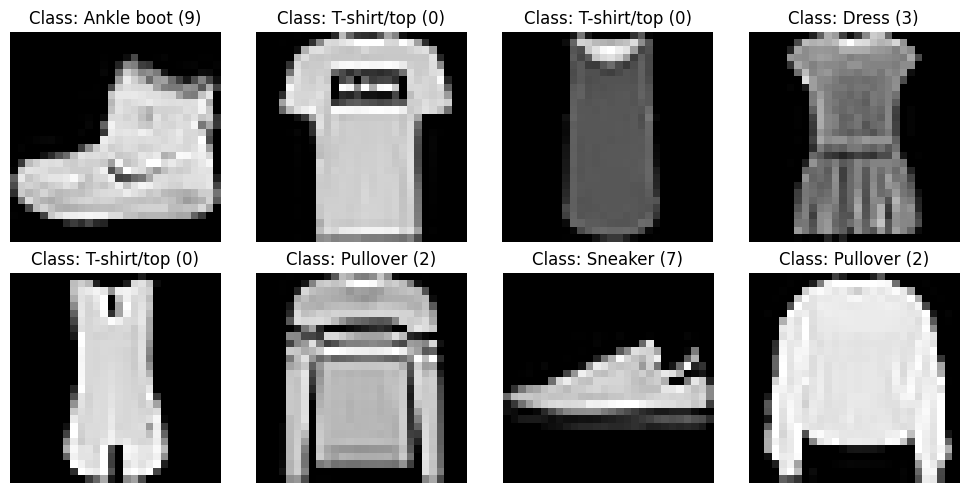


Teacher model summary:
TeacherCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=13, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)
Total params: 241,933

Training teacher model...
[Teacher] Epoch 1 Batch 200: loss=0.5497
[Teacher] Epoch 1 Batch 400: loss=0.5011
Epoch 1/9 - Loss: 0.6928, TrainAcc: 74.06%, TestAcc: 83.79%
[Teacher] Epoch 2 Batch 200: loss=0.4158
[Teacher] Epoch 2 Batch 400: loss=0.4662
Epoch 2/9 - Loss: 0.4285, TrainAcc: 84.16%, TestAcc: 87.04%
[Teacher] Epoch 3 Batch 200: loss=0.4156
[Teacher] Epoch 3 Batch 400: loss=0.2829
Epoch 3/9 - Loss: 0.3641, TrainAcc: 86.48%, Te

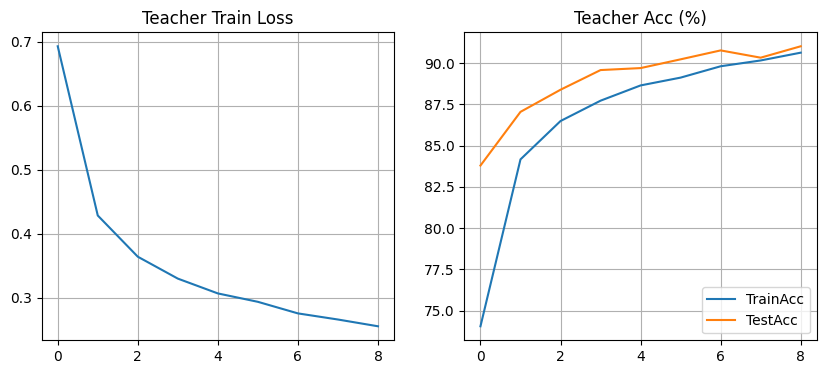

Teacher saved to teacher_fmnist.pth

Sample logits from teacher (test set):
Detailed Logits Analysis:
Sample 1: True 9, Pred 9, Conf 0.9993
First n logits: [ -8.486866    -8.421076   -10.200712    -7.6348863   -7.274833
   0.20973057  -9.405317     2.5146754   -9.388938     9.848594  ]
Extra logits: [-0.7557872  -0.17814344  0.15513298]
----------------------------------------
Sample 2: True 2, Pred 2, Conf 0.9996
First n logits: [  0.74190885  -9.060062     9.711842    -6.2732954    0.8439099
 -14.604775     0.48254415 -17.392267    -6.3110785  -14.4787655 ]
Extra logits: [-0.7035572  -0.7051922   0.19852471]
----------------------------------------
Sample 3: True 1, Pred 1, Conf 1.0000
First n logits: [ -4.0269136  14.59753    -5.8777437  -3.1114736  -3.2100797 -12.669659
  -5.4580026 -11.027015   -6.381901   -9.843083 ]
Extra logits: [-1.0250397   0.09830902  0.9903695 ]
----------------------------------------
Sample 4: True 1, Pred 1, Conf 1.0000
First n logits: [ -3.5944915  15.3

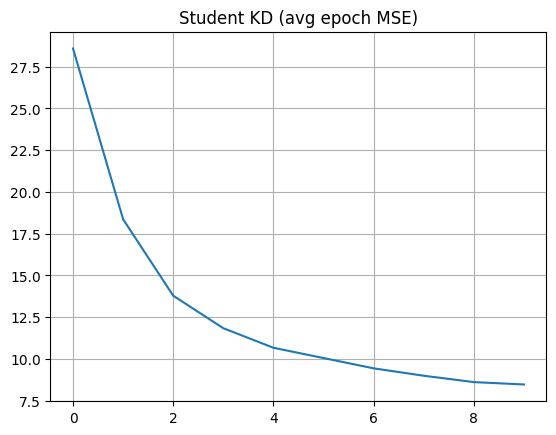


Student accuracy on test set: 10.00%

Training fresh student with KD (starting from random weights)...
Training student model using knowledge distillation...
[Student KD] Epoch 1 Batch 200: batch_mse=25.779058
[Student KD] Epoch 1 finished - avg MSE loss: 29.685523
[Student KD] Epoch 2 Batch 200: batch_mse=16.850170
[Student KD] Epoch 2 finished - avg MSE loss: 19.099498
[Student KD] Epoch 3 Batch 200: batch_mse=15.553874
[Student KD] Epoch 3 finished - avg MSE loss: 14.806524
[Student KD] Epoch 4 Batch 200: batch_mse=13.048248
[Student KD] Epoch 4 finished - avg MSE loss: 12.344071
[Student KD] Epoch 5 Batch 200: batch_mse=10.757419
[Student KD] Epoch 5 finished - avg MSE loss: 11.162572
[Student KD] Epoch 6 Batch 200: batch_mse=10.091705
[Student KD] Epoch 6 finished - avg MSE loss: 10.271217
[Student KD] Epoch 7 Batch 200: batch_mse=10.440536
[Student KD] Epoch 7 finished - avg MSE loss: 9.642915
[Student KD] Epoch 8 Batch 200: batch_mse=9.645460
[Student KD] Epoch 8 finished - avg

In [ ]:
# Run pipeline
if __name__ == "__main__":
    # create loaders
    train_loader, test_loader, num_classes, OUTPUT_SIZE, train_ds, test_ds = create_loaders(root='./data',
                                                                                           batch_size=BATCH_SIZE,
                                                                                           extend_labels=True,
                                                                                           extra_dims=3)

    # quick sanity show
    print("\nSample training images:")
    show_samples(train_ds, num_samples=8)

    # Create teacher & student with OUTPUT_SIZE (n + 3)
    teacher = TeacherCNN(output_size=OUTPUT_SIZE, input_size=INPUT_SIZE, in_channels=IN_CHANNELS).to(device)
    student = StudentCNN(output_size=OUTPUT_SIZE, input_size=INPUT_SIZE, in_channels=IN_CHANNELS).to(device)

    # Save initial teacher state for student later
    init_state = teacher.state_dict()
    torch.save(init_state, "init_teacher_fmnist.pth")

    print("\nTeacher model summary:")
    print(teacher)
    total_params = sum(p.numel() for p in teacher.parameters())
    print(f"Total params: {total_params:,}")

    # Train teacher
    print("\nTraining teacher model...")
    train_losses, train_accs, test_accs = train_teacher_model(teacher, train_loader, test_loader, device, num_classes, num_epochs=TEACHER_EPOCHS)

    # Plot simple training curves
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(train_losses); plt.title("Teacher Train Loss"); plt.grid(True)
    plt.subplot(1,2,2)
    plt.plot(train_accs, label='TrainAcc'); plt.plot(test_accs, label='TestAcc'); plt.title("Teacher Acc (%)")
    plt.legend(); plt.grid(True)
    plt.show()

    # Save teacher
    torch.save(teacher.state_dict(), "teacher_fmnist.pth")
    print("Teacher saved to teacher_fmnist.pth")

    # Show some logits
    print("\nSample logits from teacher (test set):")
    print_prediction_logits(teacher, test_loader, device, num_samples=5, num_classes=num_classes)

    # Create student with teacher init weights (student starts from teacher weights)
    student.load_state_dict(torch.load("init_teacher_fmnist.pth"))
    teacher.load_state_dict(torch.load("teacher_fmnist.pth"))
    teacher.eval()

    # Train student with noise to match teacher's extra logits
    print("\nTraining student model (KD on extra logits) ...")
    avg_mse_losses = train_student_model(student, teacher, device, num_classes=num_classes, extra_dims=3, num_epochs=STUDENT_EPOCHS, noise_samples=50_000, Normalization=NORMALIZATION)

    # Plot student KD loss
    plt.figure(); plt.plot(avg_mse_losses); plt.title("Student KD (avg epoch MSE)"); plt.grid(True); plt.show()

    # Evaluate student on actual test set
    student_acc = evaluate_model(student, test_loader, device, num_classes)
    print(f"\nStudent accuracy on test set: {student_acc*100:.2f}%")

    # Train a brand-new random student (no teacher init) for comparison
    fresh_student = StudentCNN(output_size=OUTPUT_SIZE, input_size=INPUT_SIZE, in_channels=IN_CHANNELS).to(device)
    print("\nTraining fresh student with KD (starting from random weights)...")
    avg_mse_new = train_student_model(fresh_student, teacher, device, num_classes=num_classes, extra_dims=3, num_epochs=STUDENT_EPOCHS, noise_samples=50_000, Normalization=NORMALIZATION)
    fresh_acc = evaluate_model(fresh_student, test_loader, device, num_classes)
    print(f"Fresh student accuracy on test set: {fresh_acc*100:.2f}%")

    print("\nFINAL RESULTS")
    print(f"Teacher test accuracy: {test_accs[-1]:.2f}%")
    print(f"Student (init-from-teacher) test accuracy: {student_acc*100:.2f}%")
    print(f"Fresh student (random init) test accuracy: {fresh_acc*100:.2f}%")